In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import soundfile as sf
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from IPython.display import Audio
from natsort import natsorted
from scipy.signal import stft


import alphaMusic.evaluation as evl
import alphaMusic.utils.fls_utils as fls
import alphaMusic.utils.acu_utils as acu
import alphaMusic.utils.geo_utils as geo
import alphaMusic.utils.mat_utils as mat

from alphaMusic.dataloaders import LibriSpeechDataset


from IPython.display import Audio

In [3]:
path_to_librispeech = Path('..','data','LibriSpeech','dev-clean')
path_to_recipe = Path('..','recipes','EUSIPCO22')
print(path_to_librispeech.exists())
print(path_to_recipe.exists())

True
True


In [44]:
fs = 16000
duration_range = [6, 7]
db = LibriSpeechDataset('Librispeech', path_to_librispeech, fs, duration_range, path_to_recipe)

n_samples = 60

room_dim = [6, 5, 3]
RT60_range = [0.25]
SNR_range = [5]
DRR_range = [1.]
n_srcs = 2

n_mics = 4
radius = 0.08
array_setup = acu.get_linear_array(n_mics, radius)
array_center = np.c_[[3.2, 2.1, 1.2]]

noise_type = 'cafet'
path_to_noise = Path('..','data','cafet_noise.wav')
# path_to_noise = None

def range2str(rng):
    if len(rng) > 1:
        return f'sweep'
    else:
        return str(rng[0])

rt60_name = range2str(RT60_range)
snr_name = range2str(SNR_range)
drr_name = range2str(DRR_range)
exp_name = f'N:{n_samples}_RT60:{rt60_name}_SNR:{snr_name}_nsrcs:{n_srcs}_nmics:{n_mics}_noise:{noise_type}'
print(exp_name)

path_to_output_pkl = path_to_recipe / Path(f'data/{exp_name}_data.pkl')

dataset = db.built_dataset(
    n_samples,
    room_dim, RT60_range, SNR_range, DRR_range, 
    array_setup, array_center, 
    n_srcs, path_to_noise, do_plot=False, 
    path_to_pkl=path_to_output_pkl)

dataset = db.load_dataset(path_to_output_pkl)

N:60_RT60:0.25_SNR:5_nsrcs:2_nmics:4_noise:cafet


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:27<00:00,  2.14it/s]


done
Saving

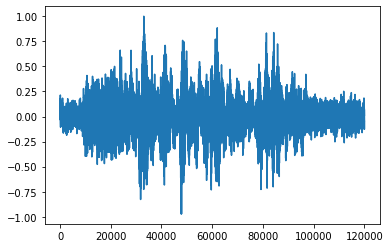

[0, 78]
{'RT60': 0.25, 'SNR': 5, 'DRR': 2.2432172620008046, 'DER': 7.100688762303669}


In [45]:
(x, doas, acu_params) = dataset[0]
x = x / np.max(np.abs(x),axis=1, keepdims=True)

sf.write('mix.wav', x.T, samplerate=16000)

plt.plot(x[0])
plt.show()
print(doas)
print(acu_params)
Audio(data=x, rate=16000)

In [46]:
from pyroomacoustics import doa
from alphaMusic.alphaMUSIC import aMUSIC

nfft = 1024
fs = 16000
minF = 500
maxF = 4000
nframes = int((2*16000)/(1024*0.5))

kwargs = {'L': array_setup.mic_pos,
          'fs': fs, 
          'nfft': nfft,
          'azimuth': np.deg2rad(np.arange(180,step=1)),
          'num_src':n_srcs,
          
}
algorithms = {
    'MUSIC': doa.music.MUSIC(**kwargs),
    'aMUSIC_est' : aMUSIC(**kwargs,alpha=3,frequency_normalization=False),
    'aMUSIC_fix' : aMUSIC(**kwargs,alpha=1.5,frequency_normalization=False),
#     'aMUSIC_gau' : aMUSIC(**kwargs,alpha=2,frequency_normalization=False),
#     'aMUSIC_tyl' : aMUSIC(**kwargs,alpha=0,frequency_normalization=False),
    'NormMUSIC': doa.normmusic.NormMUSIC(**kwargs),
    'aNormMUSIC_est' : aMUSIC(**kwargs,alpha=3,frequency_normalization=True),
    'aNormMUSIC_fix' : aMUSIC(**kwargs,alpha=1.5,frequency_normalization=True),
#     'aNormMUSIC_gau' : aMUSIC(**kwargs,alpha=2,frequency_normalization=True),
#     'aNormMUSIC_tyl' : aMUSIC(**kwargs,alpha=0,frequency_normalization=True),
    'SRP_PHAT' : doa.srp.SRP(**kwargs),
#     'FRIDA' : doa.frida.FRIDA(**kwargs, max_four=4)
    
}

In [47]:
columns = ["DOAs", "dDOA", 'algo', "DOAs_est", 'SNR', 'RT60','DRR']
predictions = {n:[] for n in columns}

do_plot = False

for n, (x, doas, acu_params) in enumerate(tqdm(dataset)):

    # STFT
    stft_signals = stft(x[:,fs:fs+nframes*nfft], fs=fs, nperseg=nfft, noverlap=0.5)[2]
    
    # OUR MUSIC
    for algo_name, algo in algorithms.items():
             
        predictions['DOAs'].append(doas)
        predictions['algo'].append(algo_name)
        if len(doas) == 2:
            predictions['dDOA'].append(np.abs(np.diff(doas)))
        else:
            predictions['dDOA'].append(np.NaN)
                                
    
#         try:
        algo.locate_sources(stft_signals, num_src=n_srcs, freq_range=[minF, maxF], mpd=10)
        predictions['SingularMatrix'].append(False)
        doa_est = np.rad2deg(algo.azimuth_recon)
        
        
        x = np.rad2deg(algo.grid.azimuth)
        y = algo.grid.values / np.max(algo.grid.values)
        
        if do_plot: plt.plot(x, y, label=algo_name)
        
        x = [int(d) for d in doa_est]
        if do_plot: plt.scatter(x, y[x], marker='v')

        predictions['DOAs_est'].append(doa_est)
        predictions['SNR'].append(acu_params['SNR'])
        predictions['RT60'].append(acu_params['RT60'])
        predictions['DRR'].append(acu_params['DRR'])
    
    if do_plot: 
        for doa in doas:
            plt.axvline(x=doa)
        plt.title(acu_params['RT60'])
        plt.legend()
        plt.show()
    

df_predictions = pd.DataFrame.from_dict(predictions)

100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:09<00:00,  6.06it/s]


In [60]:
fls.save_to_pkl(path_to_recipe / Path(f'{exp_name}_results.pkl'), df_predictions)
print(path_to_recipe / Path(f'{exp_name}_results.pkl'))
df_predictions

../recipes/EUSIPCO22/N:60_RT60:0.25_SNR:5_nsrcs:2_nmics:4_noise:cafet_results.pkl


,DOAs,dDOA,algo,DOAs_est,SNR,RT60,DRR,SingularMatrix
0,"[0, 78]",[78],MUSIC,"[79.0, 14.0]",5,0.25,2.243217,False
1,"[0, 78]",[78],aMUSIC_est,"[59.00000000000001, 82.0]",5,0.25,2.243217,False
2,"[0, 78]",[78],aMUSIC_fix,"[59.00000000000001, 82.0]",5,0.25,2.243217,False
3,"[0, 78]",[78],NormMUSIC,"[10.0, 79.0]",5,0.25,2.243217,False
4,"[0, 78]",[78],aNormMUSIC_est,"[12.000000000000002, 79.0]",5,0.25,2.243217,False
...,...,...,...,...,...,...,...,...
415,"[59, 3]",[56],aMUSIC_fix,"[59.00000000000001, 29.999999999999996]",5,0.25,2.430107,False
416,"[59, 3]",[56],NormMUSIC,"[9.0, 59.00000000000001]",5,0.25,2.430107,False
417,"[59, 3]",[56],aNormMUSIC_est,"[5.0, 59.00000000000001]",5,0.25,2.430107,False
418,"[59, 3]",[56],aNormMUSIC_fix,"[5.0, 59.00000000000001]",5,0.25,2.430107,False


In [57]:
df = pd.DataFrame()

for r, row in df_predictions.iterrows():
    
    # compute metrics
    doas_est = row['DOAs_est']
    doas_ref = row['DOAs']
    
    metrics = evl.compute_ssl_metrics(doas_est, doas_ref)
    
    df.at[r,'algo'] = row['algo']
    df.at[r,'dDOA'] = row['dDOA']
#     print([int(d) for d in doas_ref], row['algo'], [int(d) for d in doas_est])
    
    # params
#     df.at[r,'nsrcs'] =  res_dict['nsrcs']
#     df.at[r,'SNR'] = res_dict['acu_params']['SNR']
#     df.at[r,'RT60'] = res_dict['acu_params']['RT60']
#     df.at[r,'DRR'] =  res_dict['acu_params']['DRR']
    
    
    # metrics
    df.at[r,'MAE'] = metrics['MAE']
    df.at[r,'RMSE'] = metrics['RMSE']
    df.at[r,'ACC5'] = metrics['ACC5']
    df.at[r,'ACC10'] = metrics['ACC10']
    df.at[r,'MISS'] = metrics['MISS']
    df.at[r,'SNR'] = row['SNR']
    df.at[r,'RT60'] = row['RT60']
    
#     df.at[r,'est'] = np.array(doas_est)
#     df.at[r,'ref'] = np.array(doas_ref)

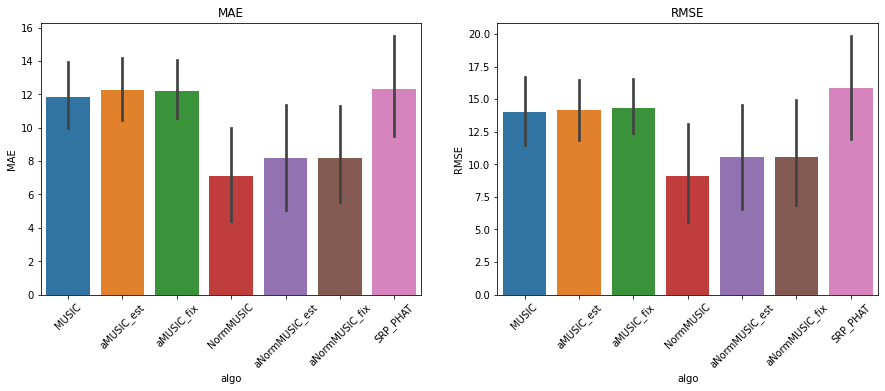

In [51]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('MAE')
sns.barplot(x='algo', y='MAE', data=df)
plt.xticks(rotation=45)
plt.subplot(122)
plt.title('RMSE')
sns.barplot(x='algo', y='RMSE', data=df)
plt.xticks(rotation=45)
plt.show()

In [52]:
for rt60 in RT60_range:
    for algo_name, algo in algorithms.items():
        
        curr_df = df.loc[(df['algo'] == algo_name) & (df['RT60'] == rt60)]
        mean = np.mean(curr_df['RMSE'].to_numpy())
        std  = np.std(curr_df['RMSE'].to_numpy())

        print(rt60, algo_name, mean, std)

0.25 MUSIC 14.046371635336646 10.281834007057139
0.25 aMUSIC_est 14.1879060128348 8.818256987880286
0.25 aMUSIC_fix 14.339737112070617 8.481662939740728
0.25 NormMUSIC 9.085240362746001 14.881758662351176
0.25 aNormMUSIC_est 10.542943188907682 15.841023186086554
0.25 aNormMUSIC_fix 10.592134908807044 15.86841762979634
0.25 SRP_PHAT 15.83334309285384 15.384144863158443


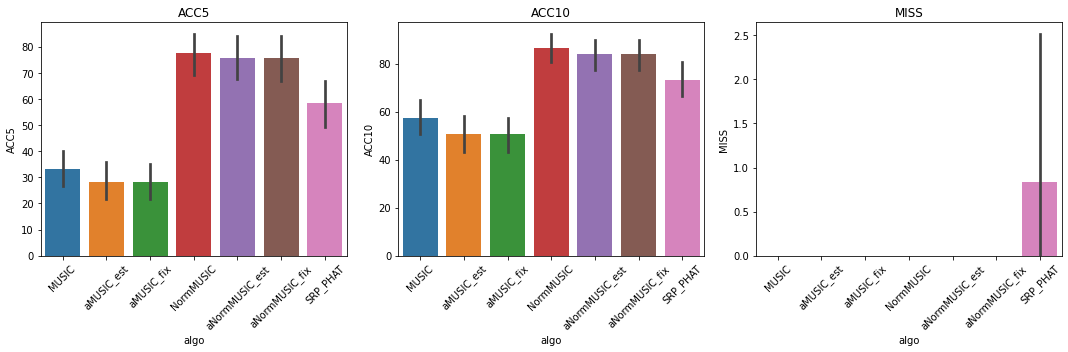

In [53]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('ACC5')
sns.barplot(x='algo', y='ACC5', data=df)
plt.xticks(rotation=45)
plt.subplot(132)
plt.title('ACC10')
sns.barplot(x='algo', y='ACC10', data=df)
plt.xticks(rotation=45)
plt.subplot(133)
plt.title('MISS')
sns.barplot(x='algo', y='MISS', data=df)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='RT60', ylabel='RMSE'>

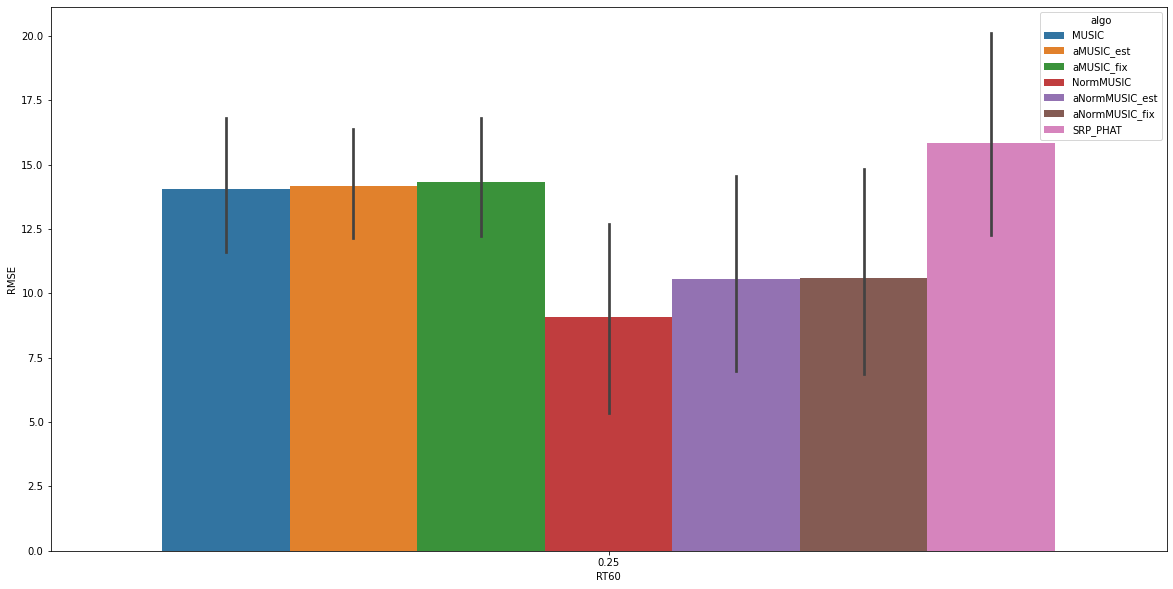

In [54]:
plt.figure(figsize=(20,10))
sns.barplot(x='RT60',y='RMSE',hue='algo',data=df)

<AxesSubplot:xlabel='RT60', ylabel='ACC5'>

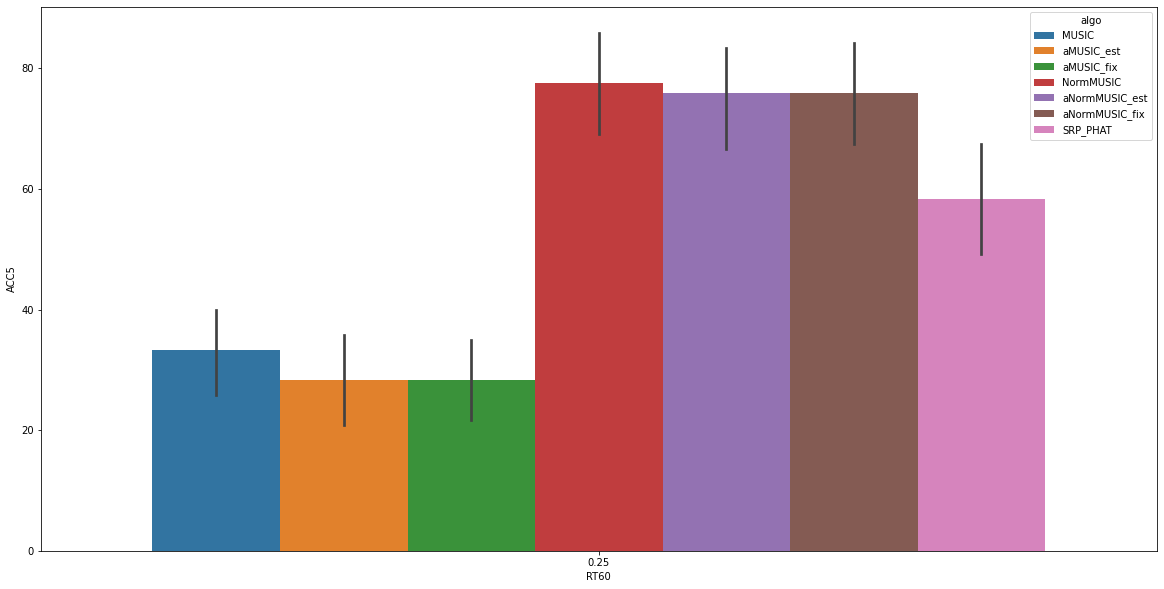

In [55]:
plt.figure(figsize=(20,10))
sns.barplot(x='RT60',y='ACC5',hue='algo',data=df)

<AxesSubplot:xlabel='RT60', ylabel='ACC10'>

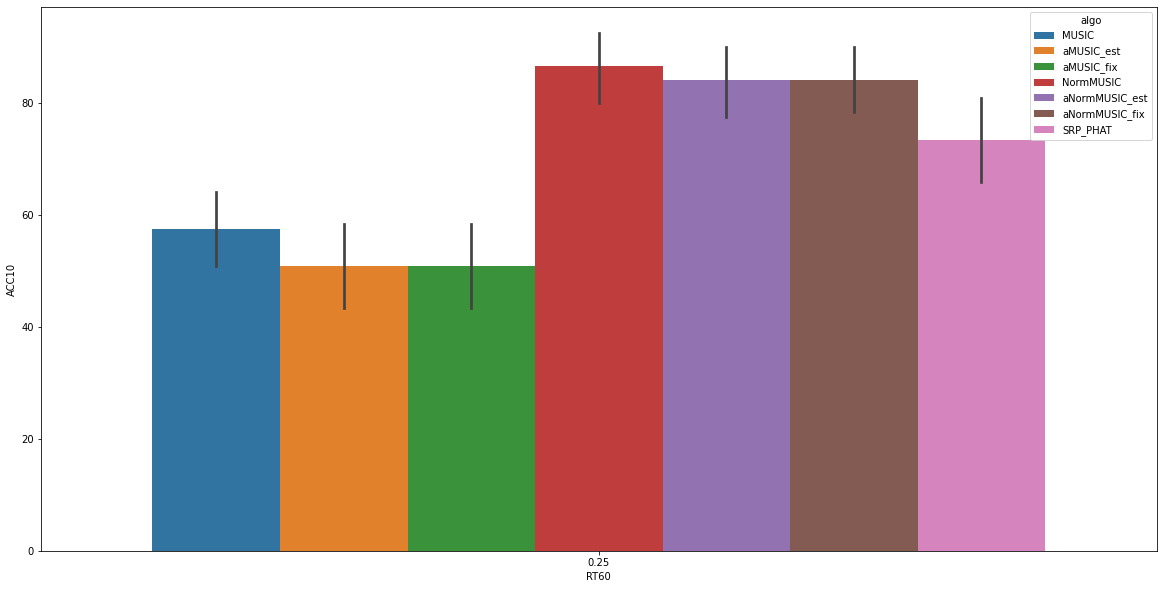

In [56]:
plt.figure(figsize=(20,10))
sns.barplot(x='RT60',y='ACC10',hue='algo',data=df)

<AxesSubplot:xlabel='dDOA', ylabel='MAE'>

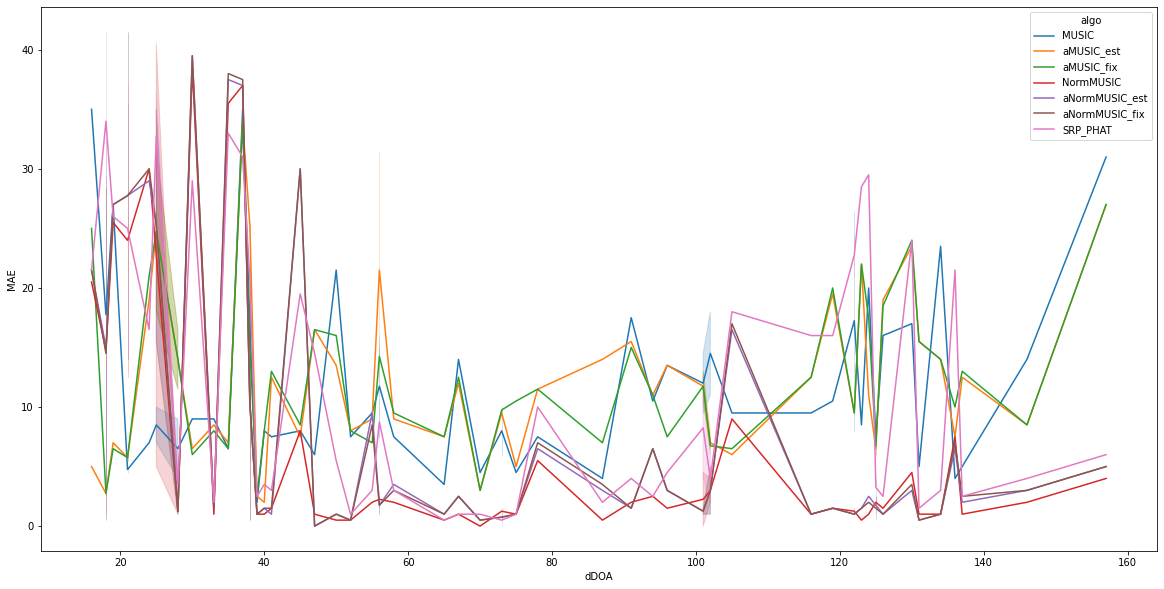

In [59]:
plt.figure(figsize=(20,10))
sns.lineplot(x='dDOA',y='MAE',hue='algo',data=df)